In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

Wczytuję dane

In [2]:
dane=pd.read_csv('titanic.csv')

Sprawdzam co jest nie tak z danymi

In [3]:
dane.info()
dane.head(20)
dane.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         793 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,793.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,33.123938,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,51.578312,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.925000,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.500000,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN


Zakładam że jeśli Wiek jest mniejszy niż 1 to jest to błąd przy wpisywaniu i poprawiam zapis
Usuwam część po przecinku wieku
Braki uzupełniam średnią wieku dla danej płci oraz klasy podróży 

In [4]:

dane.loc[dane['Age'] < 1, 'Age'] = dane.loc[dane['Age'] < 1, 'Age'] * 10
dane.loc[dane['Age']%1!=0, 'Age']=dane.loc[dane['Age']%1!=0, 'Age'].floordiv(1)
age_medians=dane.groupby(['Pclass', 'Sex'])['Age'].median()
def fill_age(row):
    if pd.isna(row['Age']):
        return age_medians.loc[row['Pclass'], row['Sex']]
    return row['Age']
dane['Age'] = dane.apply(fill_age, axis=1)

Cenę biletu uzupełniam szukając osób z tym samym biletem i podaną ceną
Resztę uzupełniam średnią ceny dla danej klasy

In [5]:
ticket_to_fare=dane.dropna(subset=['Fare']).groupby('Ticket')['Fare'].first()
class_to_fare=dane.groupby('Pclass')['Fare'].mean()
dane["Fare"]=dane['Fare'].fillna(dane['Ticket'].map(ticket_to_fare))
dane.loc[dane['Fare'].isna(), 'Fare']=dane.loc[dane['Fare'].isna(), 'Pclass'].map(class_to_fare)

Uzupełniam brakujące dane najczęściej powtarzającą się wartością(Brakuje 2 Wartości i tak nic to nie zmieni)

In [6]:
dane.loc[dane['Embarked'].isna(), 'Embarked']='S'

Usuwam niepotrzebne kolumny i zamieniam kolumnę Embarked oraz Sex tak aby mieć dane w pełni numeryczne(1 dla male i 0 dla female)

In [7]:
dane.drop(columns=['PassengerId', 'Name', 'Cabin', 'Ticket'], inplace=True)
dane=pd.get_dummies(dane, columns=['Embarked'], prefix='Embarked')
dane['Sex']=dane['Sex']=='male'
for col in dane.columns:
    if col != 'Fare':
        dane[col]=dane[col].astype(int)

Dodaję kolumny FamilySize co jest wielkością rodziny na pokładzie i IsAlone czyli wartość (1/0) czy ktoś jest sam czy też nie

In [8]:
dane['FamilySize']=dane['SibSp'] + dane['Parch'] + 1
dane['IsAlone'] = (dane['FamilySize'] == 1).astype(int)




Zależność przeżywalności od płci(Znacznie więcej kobiet przeżyło niż mężczyzn)

<Axes: xlabel='Sex', ylabel='Survived'>

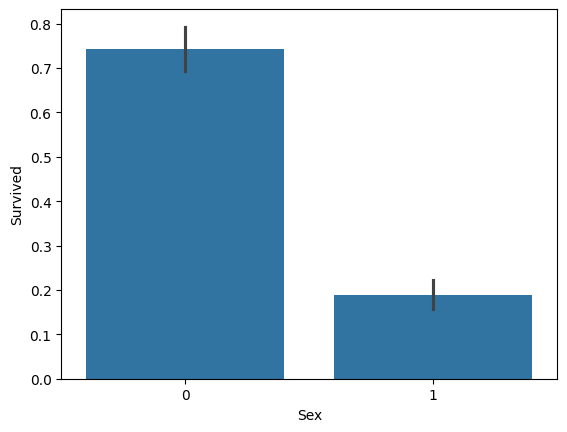

In [9]:
sns.barplot(data=dane, x='Sex', y='Survived' )

Zależność klasy podróży na przeżywalność(wyższa klasa-większe szanse na przeżycie)

<Axes: xlabel='Pclass', ylabel='Survived'>

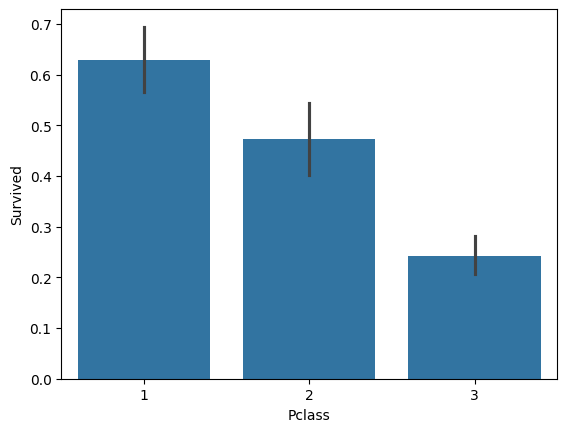

In [10]:
sns.barplot(data=dane, x='Pclass', y='Survived')

Przedział wiekowy do przeżywalności(20-30 największa przeżywalność)

<Axes: xlabel='Age', ylabel='Count'>

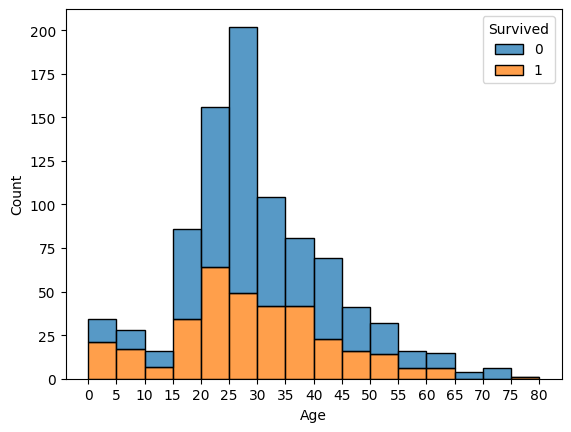

In [11]:
bins1=np.arange(0, dane['Age'].max()+5, 5)
plt.xticks(bins1)
sns.histplot(data=dane, x='Age', hue='Survived', multiple='stack', bins=bins1)

Zależność Ceny od przeżywalności-im więcej zapłacisz tym większa szansa na przeżycie

<Axes: xlabel='Survived', ylabel='Fare'>

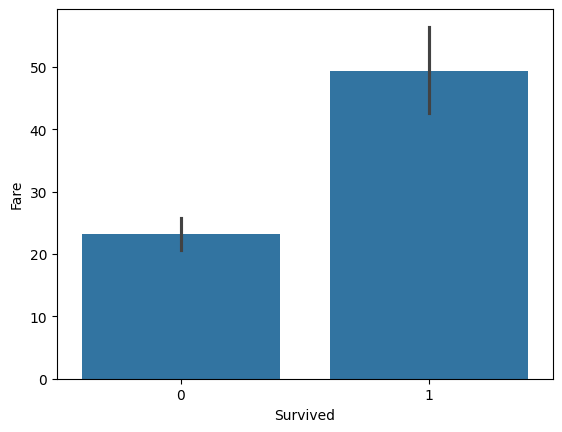

In [12]:
sns.barplot(data=dane, x='Survived', y='Fare')

Zależność Wielkości rodziny na pokładzie do przeżywalności(Jak jest was 4 to macie największą szansę przeżycia)

<Axes: xlabel='FamilySize', ylabel='Survived'>

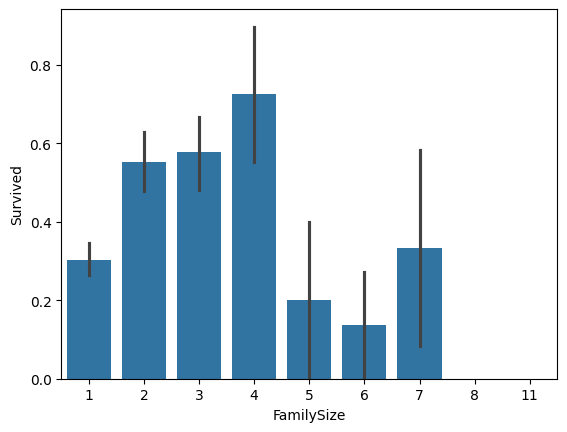

In [13]:
sns.barplot(data=dane, x='FamilySize', y='Survived')

Więcej samotnych niż z rodziną kobiet przeżyło podczas gdy dla mężczyzn było odwrotnie

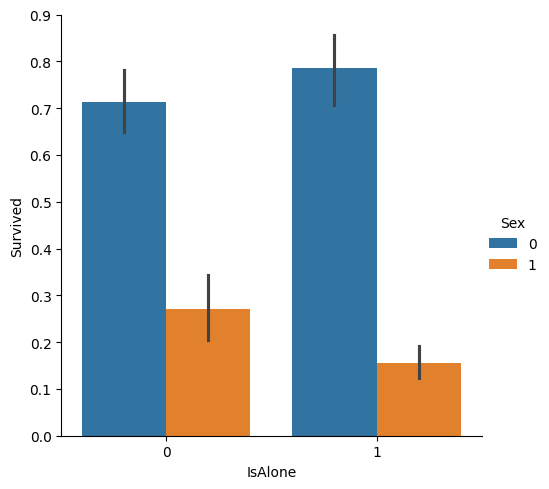

In [14]:
sns.catplot(data=dane, x='IsAlone', y='Survived', hue='Sex', kind='bar')

Rozkład wieku w grupach klasy podróży i wieku

<Axes: xlabel='Pclass', ylabel='Age'>

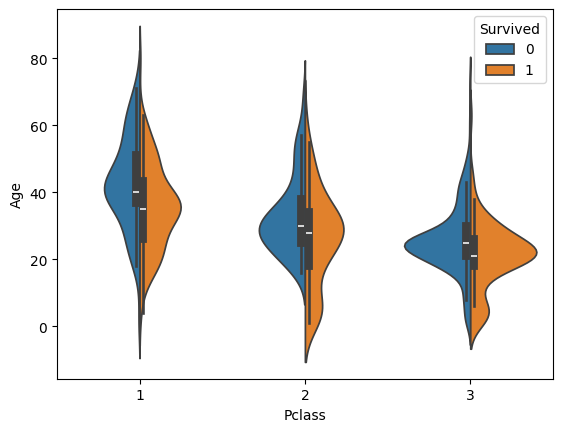

In [15]:
sns.violinplot(data=dane, x='Pclass', y='Age', hue='Survived', split=True)

Prosta Heatmapa

<Axes: >

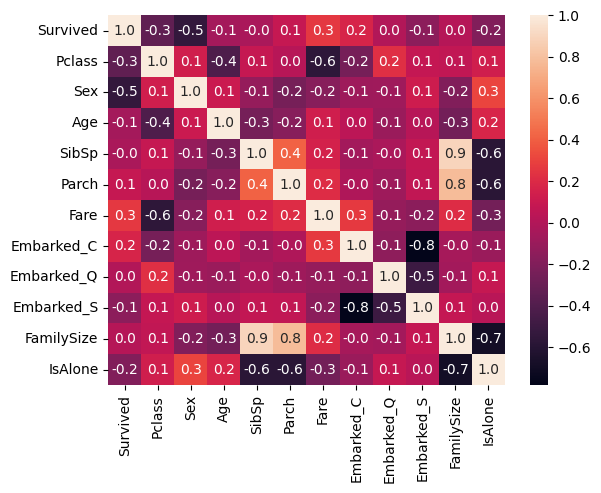

In [16]:
sns.heatmap(dane.corr(), annot=True, fmt='.1f')

Najwięcej ludzi z Southampton przeżyło

<Axes: xlabel='None'>

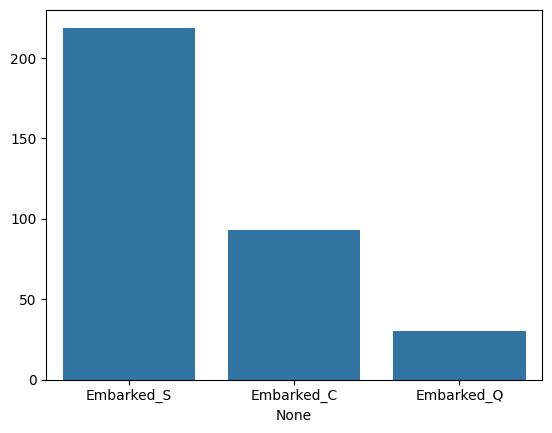

In [17]:
sursived=dane[['Embarked_S','Embarked_C','Embarked_Q']].where(dane['Survived'] == 1).sum()
sns.barplot(x=sursived.index, y=sursived.values)


Dzielę dane na treningowe i testowe

In [18]:
X=dane.drop('Survived', axis=1)
y=dane['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Porównuję kilka modeli aby wybrać najlepszy, zaczynam od KNN przy okazji sprawdzam k od 1 do 31 aby sprawdzić które da mi największą dokładność

In [19]:
print("\n--- Model KNN ---")
k_range=list(range(1, 31))
k_score=[]
for k in k_range:
    model=KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    k_score.append(scores.mean())
optimal_k=k_range[k_score.index(max(k_score))]
print(f"Najlepsza wartość k to: {optimal_k}")
model=KNeighborsClassifier(n_neighbors=optimal_k)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
print(f"Dokładność modelu KNN: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


--- Model KNN ---
Najlepsza wartość k to: 3
Dokładność modelu KNN: 0.7094972067039106
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       105
           1       0.68      0.55      0.61        74

    accuracy                           0.71       179
   macro avg       0.70      0.69      0.69       179
weighted avg       0.71      0.71      0.70       179



Do modelu SVM najpierw testuję które dane dadzą najlepsze rezultaty, włączam jednocześnie wykorzystanie wszystkich rdzeni procesora aby proces ten zachodził w miarę szybko

In [20]:
print("\n--- Model SVM ---")
param_grid = {'C': [1, 10], 'gamma': [0.01, 0.1], 'kernel': ['rbf'] }
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Najlepsze parametry: {grid_search.best_params_}")
model = grid_search.best_estimator_
y_pred_svm = model.predict(X_test)
print(f"Dokładność modelu SVM: {accuracy_score(y_test, y_pred_svm)}")
print(classification_report(y_test, y_pred_svm))


--- Model SVM ---
Najlepsze parametry: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Dokładność modelu SVM: 0.7877094972067039
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       105
           1       0.78      0.68      0.72        74

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.78       179



Dla random foresta też szukam najlepszych możliwych parametrów

In [21]:
print("\n--- Model Random Forest ---")


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(f"Najlepsze parametry: {grid_search.best_params_}")

model = grid_search.best_estimator_
model.fit(X_train, y_train)
y_pred_rf = model.predict(X_test)
print(f"Dokładność modelu Random Forest: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))


--- Model Random Forest ---
Najlepsze parametry: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
Dokładność modelu Random Forest: 0.8156424581005587
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179



Porównuję jak poradziły sobie poszczególne modele

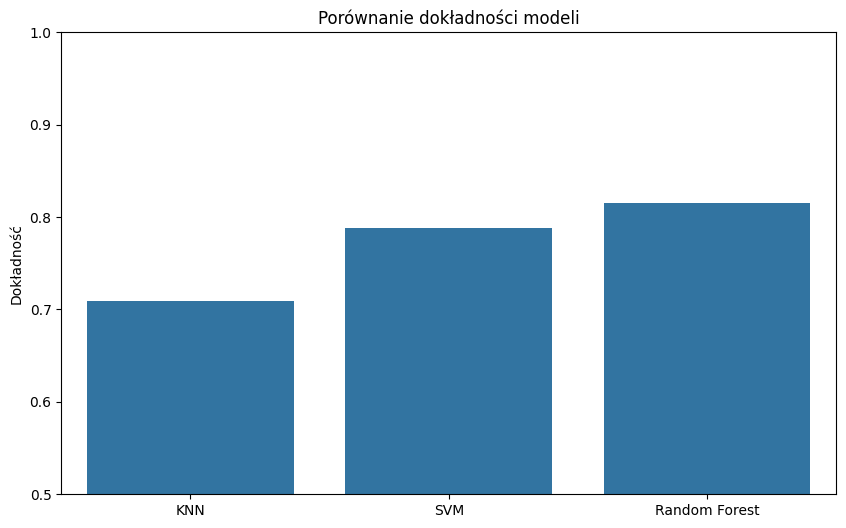

In [22]:
models = ['KNN', 'SVM', 'Random Forest']
accuracies = [
    accuracy_score(y_test, y_pred),
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_rf)
]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.ylim(0.5, 1.0)  # Dostosuj zakres według rzeczywistych wyników
plt.title('Porównanie dokładności modeli')
plt.ylabel('Dokładność')
plt.show()

Jako że najlepiej poradził sobie random forest to na jego podstawie sprawdzam ważność danych

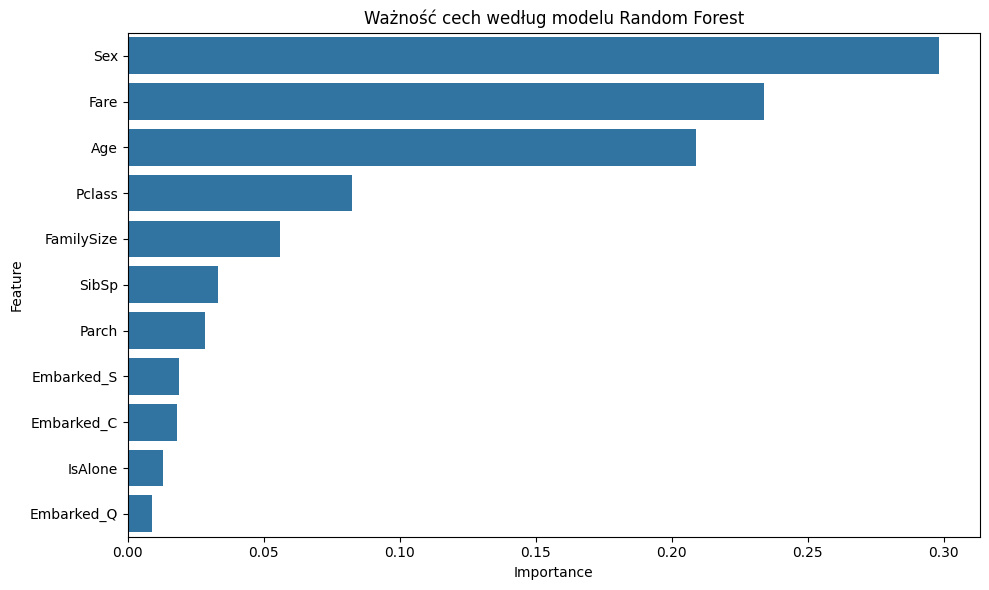

In [23]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Ważność cech według modelu Random Forest')
plt.tight_layout()
plt.show()

No i jakieś wnioski po krótce

In [24]:
print("1. Najlepszy model to:", models[accuracies.index(max(accuracies))])
print(f"2. Osiągnięta dokładność: {max(accuracies):.4f}")
print("3. Najważniejsze cechy dla klasyfikacji to:", feature_importance['Feature'].iloc[:3].tolist())



1. Najlepszy model to: Random Forest
2. Osiągnięta dokładność: 0.8156
3. Najważniejsze cechy dla klasyfikacji to: ['Sex', 'Fare', 'Age']
